In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-04 17:22:04.875372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 17:22:05.418102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-04-04 17:22:05.418554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=10,var1_u=60,CROP1=CROP,BATCH_SIZE=10)

2023-04-04 10:03:20.221625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 10:03:20.221844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 10:03:20.226984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 10:03:20.227200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 10:03:20.227376: I tensorflow/compiler/xla/stream_executo

In [3]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

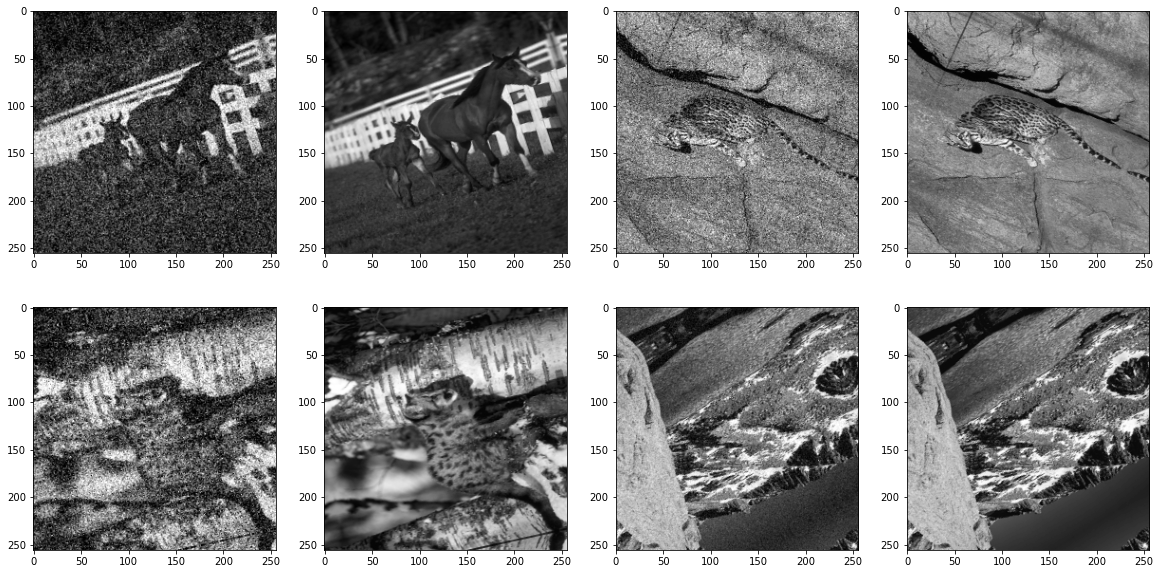

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

In [19]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            
            #var = np.random.uniform(var_d,var_u)
            var = np.random.choice([15,25,50])
            var += np.random.normal(0,10)
            var = np.clip(var,var_d,var_u)
            #print(var)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            #continue
            break
            

            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            if pre:
                x = tf.nn.conv2d(np.array([x]),kernel,[1,1,1,1],"SAME")[0]
               
            if same:
                x = y
            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [20]:
BATCH_SIZE = 50
train_var = False
var_d=5
var_u=60
pre = False
same = False

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

In [21]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

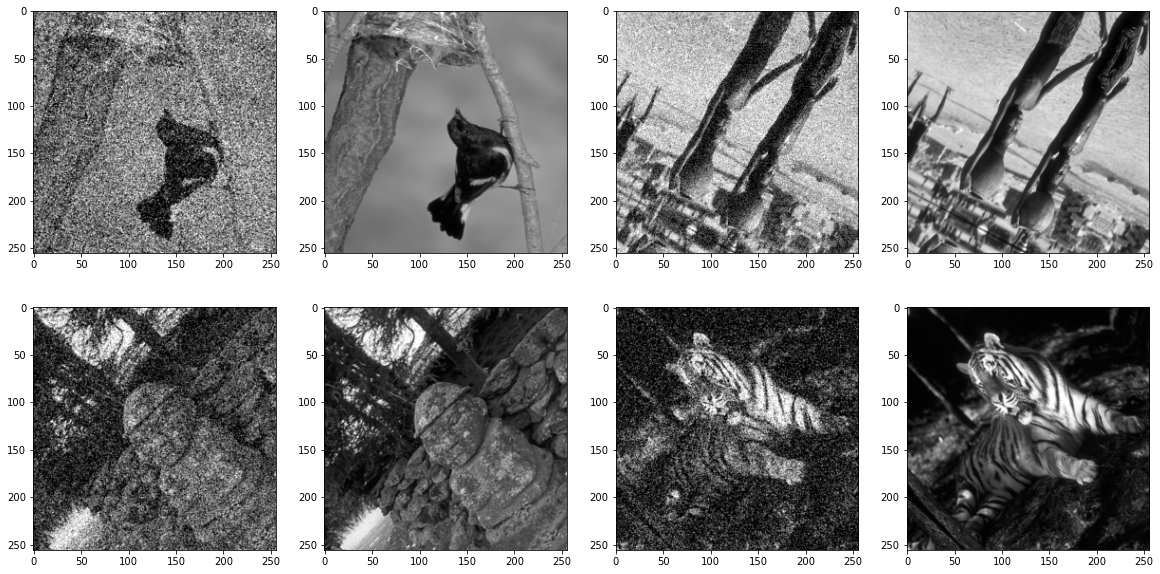

In [28]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

In [86]:
def make_embedding(input_shape,kernel_size=3,pool_size=3,CROP=256):
    
    
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(32*32, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    embedding =  tf.keras.Model(inputs,x)
    embedding.load_weights('/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/thesis/23_jan/border/checkpoints/embedding')
    
    for layer in embedding.layers[:-4]:
        layer.trainable = False
        
        
    
    return embedding

In [87]:
input_shape = image_size + (1,)
    
    
inputs = tf.keras.Input(shape=input_shape,name='input')
model = make_embedding(input_shape)

In [88]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 32  320         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_88 (BatchN  (None, 128, 128, 32  128        ['conv2d_48[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 separable_conv2d_77 (Separable  (None, 32, 32, 64)  4736        ['activation_95[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_77[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_95[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_52

In [80]:
kernel_size=3
pool_size=3

inputs = tf.keras.layers.Input(input_shape)
x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [16,32,64,128]:
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

    # Project residual
    residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = tf.keras.layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = tf.keras.layers.SeparableConv2D(32*32, kernel_size, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

embedding =  tf.keras.Model(inputs,x)
embedding.load_weights('/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/thesis/23_jan/border/checkpoints/embedding')

for layer in embedding.layers:
    layer.trainable = False

In [81]:
embedding.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 128, 128, 32  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_77 (BatchN  (None, 128, 128, 32  128        ['conv2d_42[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 separable_conv2d_68 (Separable  (None, 32, 32, 64)  4736        ['activation_84[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_68[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_84[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_46

In [85]:
embedding.layers[:-4]